In [1]:
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import pywt
import seaborn
from statsmodels.robust import mad
from scipy import signal
import data_reader, features
from alpha_vantage.timeseries import TimeSeries 
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
# import numpy as np
from tensorflow import set_random_seed

Using TensorFlow backend.


In [2]:
def calc_returns(df):
    df['returns'] = df.pct_change()
    df['log-returns'] = np.log(df.iloc[:,0]).diff()
    df['up-down'] = np.sign(df['log-returns'])
    df_dropna = df.dropna()
    return df, df_dropna

def remove_na(df):
    df = df[df['returns'].notna()]
    return df


def get_cwt_features(scale_bot,scale_top,scale_incr,data):
    scales = np.arange(scale_bot,scale_top,step=scale_incr)

    cwt = features.plot_wavelet(time, data, scales)
    # print(type(cwt))
    cwt_features = pd.DataFrame(cwt).T
    cwt_features.set_index(returns.index,inplace=True)
    return cwt_features

def prep_features(data,history_points):
    hist = np.array([data[i:i + history_points].copy() for i in range(len(data) - history_points)])
    return hist

def prep_labels(data,history_points):
    hist_labels = np.array([data[i + history_points].copy() for i in range(len(data) - history_points)])
    hist_labels = np.expand_dims(hist_labels, -1)
    return hist_labels

def split_data(feats, labels, test_split):
    assert feats.shape[0] == labels.shape[0]
    n = int(labels.shape[0]*test_split)
    feature_train = feats[:n]
    label_train = labels[:n]
    feature_test = feats[n:]
    label_test = labels[n:]
    return feature_train, label_train, feature_test, label_test

def test(hist_feats,feature_train,feature_test,label_train,label_test,epoch,batch):
    feat_shape_ax1 = hist_feats.shape[1]
    feat_shape_ax2 = hist_feats.shape[2]
    lstm_input = Input(shape=(feat_shape_ax1, feat_shape_ax2), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(1, name='dense_1')(x)
    # output = Activation('linear', name='linear_output')(x)
    output = Activation('sigmoid', name='linear_output')(x)
    model = Model(inputs=lstm_input, outputs=output)

    adam = optimizers.Adam(lr=0.0005)

    model.compile(optimizer=adam, loss='mse')

    model.fit(x=feature_train, y=label_train, batch_size=batch, epochs=epoch, shuffle=True, validation_split=0.1)
    evaluation = model.evaluate(feature_test, label_test)
    print(evaluation)

    test_predicted = model.predict(feature_test)
    # plt.plot(test_predicted,'o')
    # plt.plot(label_test,'+')
    # plt.legend(['predicted','real'])
    # plt.show()
    return test_predicted, label_test

# not used
def test2(hist_feats,feature_train,feature_test,label_train,label_test,epoch):
    feat_shape_ax1 = hist_feats.shape[1]
    feat_shape_ax2 = hist_feats.shape[2]
    lstm_input = Input(shape=(feat_shape_ax1, feat_shape_ax2), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(1, name='dense_1')(x)

    y = LSTM(50, name='lstm_1')(x)
    y = Dropout(0.2, name='lstm_dropout_1')(y)
    y = Dense(64, name='dense_0')(y)
    y = Activation('sigmoid', name='sigmoid_0')(y)
    y = Dense(1, name='dense_1')(y)

    output = Activation('sigmoid', name='linear_output')(y)
    model = Model(inputs=lstm_input, outputs=output)

    adam = optimizers.Adam(lr=0.0005)

    model.compile(optimizer=adam, loss='mse')

    model.fit(x=feature_train, y=label_train, batch_size=batch, epochs=epoch, shuffle=True, validation_split=0.1)
    evaluation = model.evaluate(feature_test, label_test)
    print(evaluation)

    test_predicted = model.predict(feature_test)
    # plt.plot(test_predicted,'o')
    # plt.plot(label_test,'+')
    # plt.legend(['predicted','real'])
    # plt.show()
    return test_predicted, label_test

def test_stats(predicted, real):
    c = 0
    s = 0
    for i in range(len(predicted)):
        if (predicted[i] > 0) and (real[i] > 0):
            c = c+1
        if (predicted[i] < 0) and (real[i] < 0):
            c = c+1
        s = s+1
    print('da',c/s)
    pct_correct_da = c/s
    
    return pct_correct_da

In [5]:
start = '2018-01-01'
end = '2019-01-10'
ticker = 'AAPL'

df = data_reader.download(ticker,start,end)


opens = df['adjusted close'].to_frame()
opens, returns = calc_returns(opens)
print(opens)


signal = df['adjusted close'].dropna().to_numpy()
log_signal = returns['log-returns'].dropna().to_numpy()


data = log_signal
N = len(data)
t0=0
dt=1/365
time = np.arange(0, N) * dt + t0

            adjusted close   returns  log-returns  up-down
2018-01-02        166.3530       NaN          NaN      NaN
2018-01-03        166.3240 -0.000174    -0.000174     -1.0
2018-01-04        167.0966  0.004645     0.004634      1.0
2018-01-05        168.9990  0.011385     0.011321      1.0
2018-01-08        168.3713 -0.003714    -0.003721     -1.0
...                    ...       ...          ...      ...
2019-01-04        145.3238  0.042689     0.041803      1.0
2019-01-07        145.0003 -0.002226    -0.002229     -1.0
2019-01-08        147.7645  0.019063     0.018884      1.0
2019-01-09        150.2738  0.016982     0.016839      1.0
2019-01-10        150.7541  0.003196     0.003191      1.0

[258 rows x 4 columns]


In [4]:
# calculate the wavelet coefficients
# coeff = pywt.wavedec( x, wavelet, mode="smooth")#, level=2)
# print(coeff)
# see_shape = np.array(coeff)
# calculate a threshold
# sigma = mad( coeff[-level] )
# changing this threshold also changes the behavior,
# but I have not played with this very much
# uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
# coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
# reconstruct the signal using the thresholded coefficients
# y = pywt.waverec( coeff, wavelet, mode="smooth" )
# print(y)


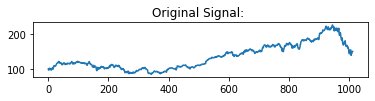

orig 1013
data 511
coeff 511
data 260
coeff 260
data 134
coeff 134
data 71
coeff 71
data 40
coeff 40


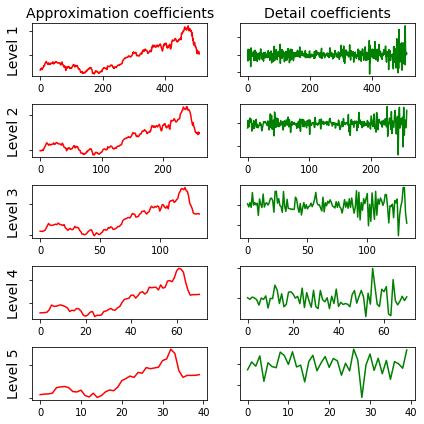

In [5]:
# x = np.linspace(0, 1, num=2048)
# chirp_signal = np.sin(250 * np.pi * x**2)

data = signal

fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(data)
plt.show()
    

waveletname = 'sym5'
# waveletname = 'db9'
print('orig',len(data))

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
out_approx = []
out_detail = []
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    print('data',len(data))
    print('coeff',len(coeff_d))
    
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    out_approx = data
    out_detail = coeff_d
plt.tight_layout()
plt.show()

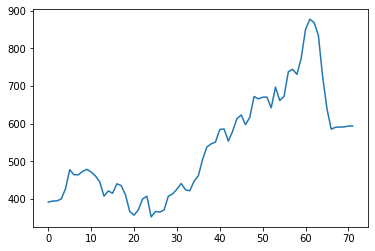

In [6]:
reconstr = pywt.idwt(out_approx,out_detail,waveletname)
plt.plot(reconstr)

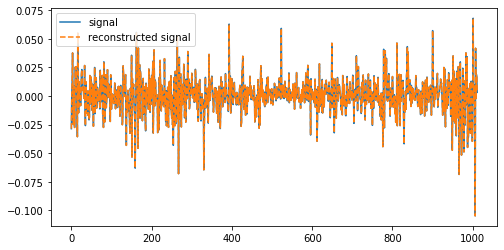

In [8]:
# x = [1,4,2,5,6,2]
wavelet = 'db2'
level = 1
title = None

(cA1, cD1) = pywt.dwt(log_signal, 'db9', 'smooth')
reconstructed_signal = pywt.idwt(cA1, cD1, 'db9', 'smooth')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(log_signal, label='signal')
ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
# plt.show()
# plt.plot(x)
# plt.plot(y)
# plt.legend(('x','y'))

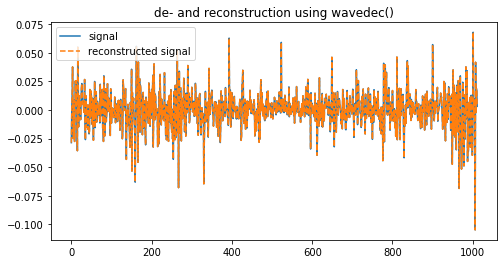

In [136]:
wavelet = 'db1'
data = log_signal
coeffs = pywt.wavedec(data, wavelet,mode='smooth')
reconstructed_signal = pywt.waverec(coeffs, wavelet,mode='smooth')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(data, label='signal')
ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

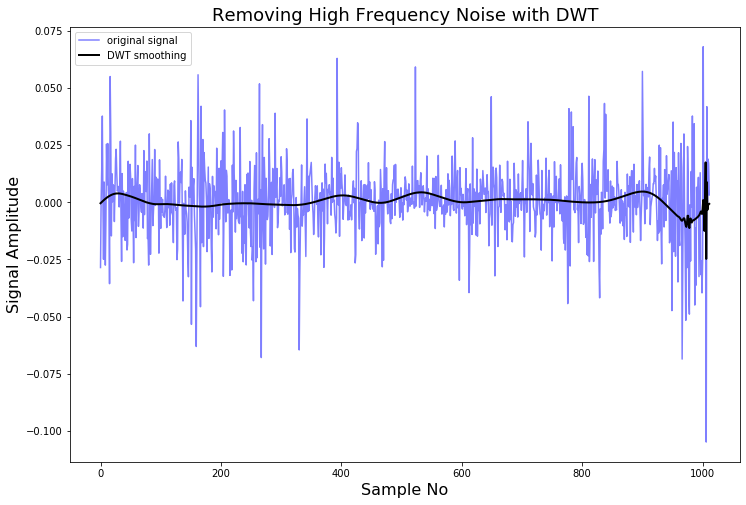

In [137]:
def lowpassfilter(signal, thresh, wavelet="db8"):
    thresh_calc = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh_calc, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

data = log_signal

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(data, thresh=0.9)
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

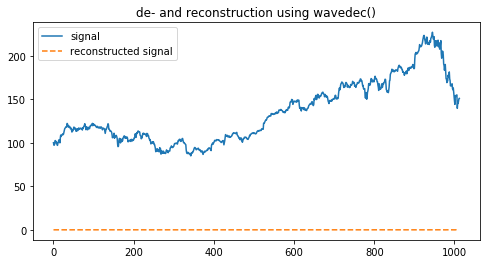

In [138]:
def lowpassfilter2(signal, thresh, wavelet="db8"):
    thresh_calc = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    orig = coeff
    coeff[1:] = (pywt.threshold(i, value=thresh_calc, mode="soft" ) for i in coeff[1:])
    return orig, coeff

[orig, coeff] = lowpassfilter2(signal,thresh=0.7)
# print(len(orig))
# print(orig)
rec_signal = pywt.waverec(orig,wavelet='db8', mode="per")
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(signal, label='signal')
ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()


1012


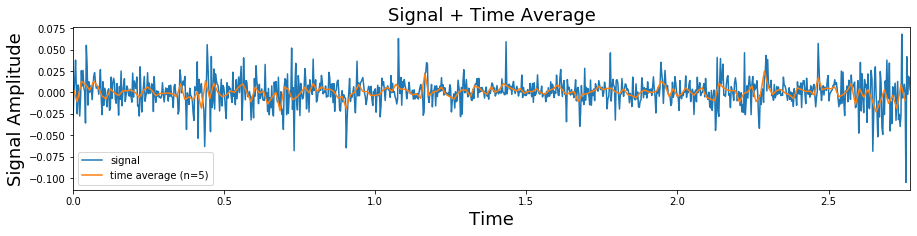

here 199
1012
1012
199
1012


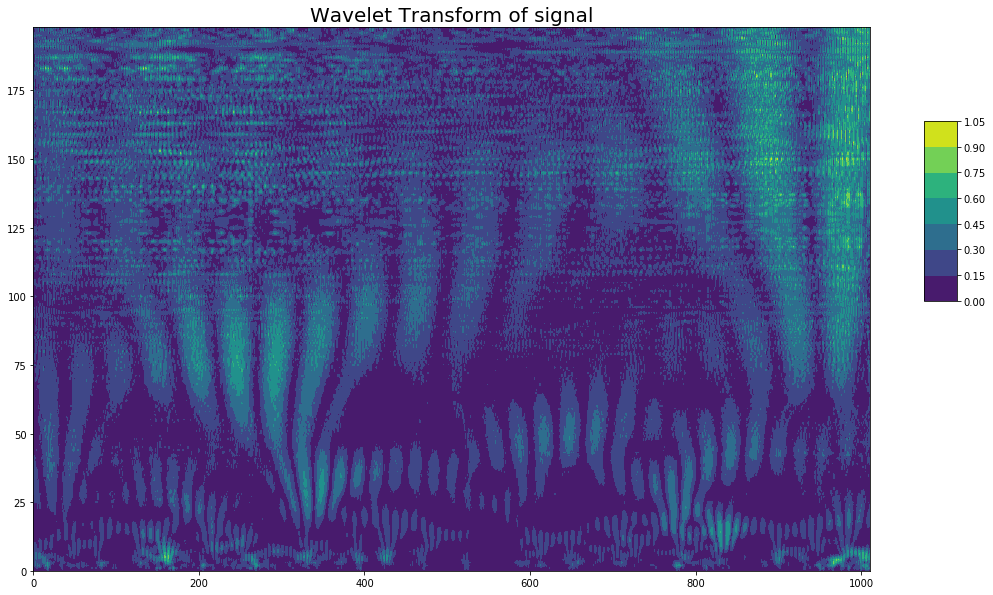

In [15]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_wavelet(time, signal, scales, 
                 waveletname = 'morl', 
                 title = 'Wavelet Transform of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname)#, dt)
#     power = (abs(coefficients)) ** 2
#     power = coefficients ** 2
    maximum = 0
    print('here',len(coefficients))
    for i in range(len(coefficients)):
        if max(coefficients[i]) > maximum:
            maximum = max(coefficients[i])
    power = abs(coefficients)/maximum
#     period = 1. / frequencies
#     power = coefficients
#     print(power[0])
    print(len(signal))
    print(len(power[0]))
    print(len(frequencies))
    print(len(time))
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(power) #time, frequencies, power) #,cmap=cmap)
    
    ax.set_title(title, fontsize=20)
#     ax.set_ylabel(ylabel, fontsize=18)
#     ax.set_xlabel(xlabel, fontsize=18)
    
#     yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
#     ax.set_yticks(np.log2(yticks))
#     ax.set_yticklabels(yticks)
#     ax.invert_yaxis()
#     ylim = ax.get_ylim()
#     ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
    return power

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
#     ax.plot(time, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    


data = log_signal
N = len(data)
print(N)
t0=0
dt=1/365
time = np.arange(0, N) * dt + t0

scales = np.arange(1, 200)
# scales = np.arange(1)
plot_signal_plus_average(time, data)
# plot_fft_plus_power(time, data)
cwt = plot_wavelet(time, data, scales)

In [142]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()

In [11]:
features = pd.DataFrame(cwt)
# print(features.shape)
# print(features)
fixed_feats = features.T
fixed_feats.set_index(opens.index,inplace=True)
print(fixed_feats.shape)
print(fixed_feats)

(1012, 127)
                 0         1         2         3         4         5    \
2015-01-05  0.003550  0.004832  0.001881  0.023320  0.027525  0.030226   
2015-01-06  0.005397  0.000680  0.025052  0.027518  0.021668  0.018992   
2015-01-07  0.000592  0.001532  0.003199  0.009083  0.003663  0.008965   
2015-01-08  0.006574  0.005322  0.032344  0.032649  0.024662  0.032927   
2015-01-09  0.005967  0.015274  0.006876  0.007745  0.026783  0.037751   
...              ...       ...       ...       ...       ...       ...   
2019-01-04  0.007793  0.004484  0.029641  0.022573  0.029868  0.048558   
2019-01-07  0.014987  0.040310  0.043456  0.016619  0.018459  0.000423   
2019-01-08  0.004257  0.042634  0.006536  0.033804  0.042393  0.039376   
2019-01-09  0.003830  0.024479  0.020526  0.008864  0.034989  0.051380   
2019-01-10  0.000313  0.006965  0.001943  0.017692  0.001048  0.025092   

                 6         7         8         9    ...       117       118  \
2015-01-05  0.023246

In [13]:
results = pd.concat([opens,fixed_feats],axis=1)
print(results)

            adjusted close   returns  log-returns         0         1  \
2015-01-05         97.3833 -0.028171    -0.028575  0.003550  0.004832   
2015-01-06         97.3924  0.000093     0.000093  0.005397  0.000680   
2015-01-07         98.7581  0.014023     0.013925  0.000592  0.001532   
2015-01-08        102.5526  0.038422     0.037702  0.006574  0.005322   
2015-01-09        102.6626  0.001073     0.001072  0.005967  0.015274   
...                    ...       ...          ...       ...       ...   
2019-01-04        145.7080  0.042689     0.041803  0.007793  0.004484   
2019-01-07        145.3837 -0.002226    -0.002228  0.014987  0.040310   
2019-01-08        148.1552  0.019063     0.018884  0.004257  0.042634   
2019-01-09        150.6711  0.016982     0.016839  0.003830  0.024479   
2019-01-10        151.1527  0.003196     0.003191  0.000313  0.006965   

                   2         3         4         5         6  ...       117  \
2015-01-05  0.001881  0.023320  0.027525  0.